<a href="https://colab.research.google.com/github/DiwakarBasnet/JetRail/blob/main/TimeForcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Data Sets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from datetime import datetime
from pandas import Series
%matplotlib inline
import warnings         # To ignore warnings
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv("https://raw.githubusercontent.com/DiwakarBasnet/JetRail/main/DateSet/Train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/DiwakarBasnet/JetRail/main/DateSet/Test.csv")

In [ ]:
# Copy of train and test data so that we still have original data
train_original = train.copy()
test_original = test.copy()

In [ ]:
train.columns, test.columns    # To know the features of dataset

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [ ]:
train.dtypes, test.dtypes      # To know the types of features in dataset

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

In [ ]:
train.shape, test.shape          # Shows the number of observation and number of features in dataset

((18288, 3), (5112, 2))

# Exploration and Preprocessing

In [ ]:
# Change the data type of Datetime from object to datetime format
train['Datetime'] = pd.to_datetime(train.Datetime, format = '%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format = '%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original.Datetime, format = '%d-%m-%Y %H:%M')
test_original['Datetime'] = pd.to_datetime(test_original.Datetime, format = '%d-%m-%Y %H:%M')

In [ ]:
# Extract year, month, date and hour to validate our hypothesis
for i in (train, test, train_original, test_original):
  i['year'] = i.Datetime.dt.year
  i['month'] = i.Datetime.dt.month
  i['day'] = i.Datetime.dt.day
  i['hour'] = i.Datetime.dt.hour

In [ ]:
# Assign 1 if day of week is weekend and 0 else
def applyer(row):
  if row.dayofweek == 5 or row.dayofweek == 6:
    return 1
  else:
    return 0

In [ ]:
train['Day of week'] = train['Datetime'].dt.dayofweek
temp = train['Datetime']
temp2 = train['Datetime'].apply(applyer)          # applyes the applyer function on all values of the series
train['weekend'] = temp2

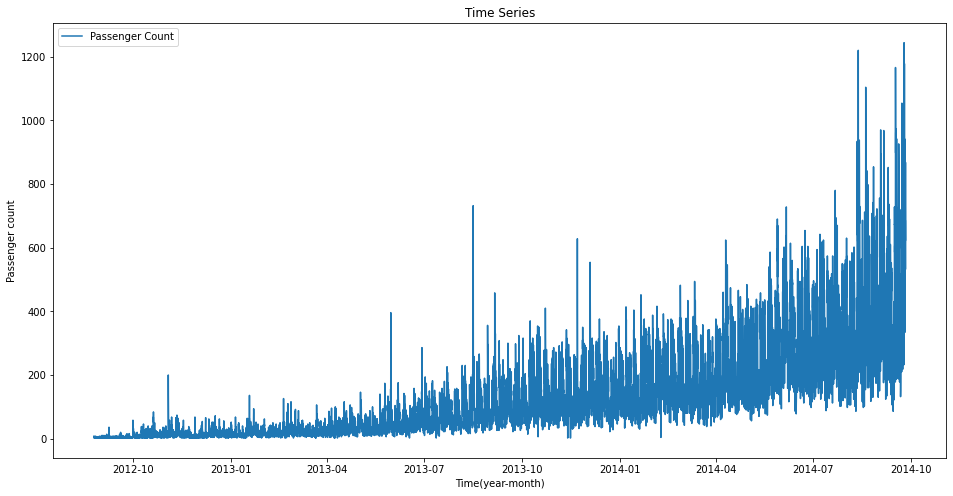

In [ ]:
train.index = train['Datetime']       # indexing the datetime to get the time period on x-axis
df = train.drop('ID',1)               # drop ID variable to get only the Datetime on x-axis
ts = df['Count']
plt.figure(figsize = (16,8))
plt.plot(ts, label = 'Passenger Count')
plt.title('Time Series')
plt.xlabel("Time(year-month)")
plt.ylabel("Passenger count")
plt.legend(loc = "best")

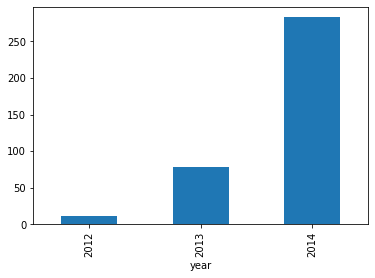

In [ ]:
# First hypothesis: Traffic will increase as year pass by
train.groupby('year')['Count'].mean().plot.bar()

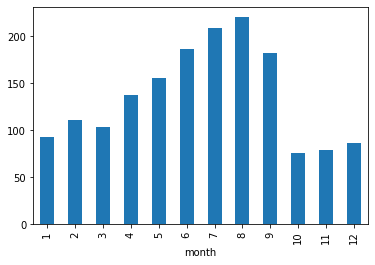

In [ ]:
# Second hypothesis: Traffic will be high from May to October
train.groupby('month')['Count'].mean().plot.bar()

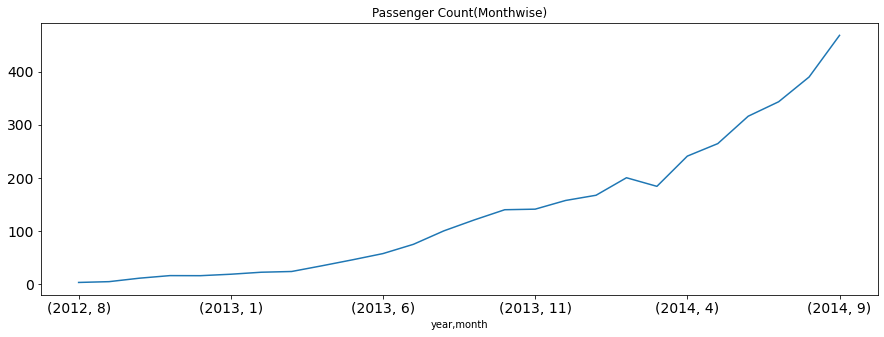

In [ ]:
# Our second hypothesis was not accurate so lets look at monthly mean of each year separately
temp = train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize = (15, 5), title = 'Passenger Count(Monthwise)', fontsize = 14)

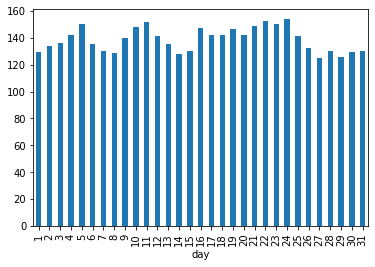

In [ ]:
train.groupby('day')['Count'].mean().plot.bar()

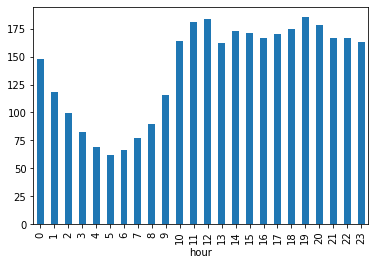

In [ ]:
# Third hypothesis: Traffic will be high during peek hour
train.groupby('hour')['Count'].mean().plot.bar()

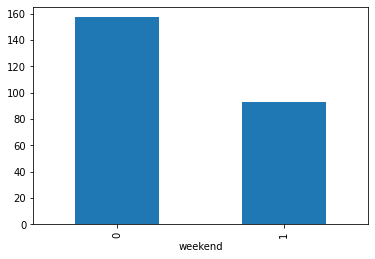

In [ ]:
# Fourth hypothesis: Traffic will be high on weekdays
train.groupby('weekend')['Count'].mean().plot.bar()

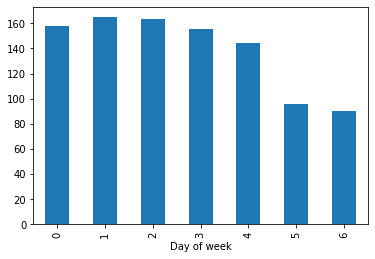

In [ ]:
# We will look at day wise passneger count, 0 is Monday and 6 is Sunday
train.groupby('Day of week')['Count'].mean().plot.bar()

In [ ]:
train = train.drop('ID', 1)   # ID variable is dropped because it has nothing to do with passenger count

In [ ]:
# We will aggregate the hourly time series to daily, weekly and monthly basis to reduce noise and hence it would be easier for a model to learn
train.Timestamp = pd.to_datetime(train.Datetime, format = '%d-%m-%Y %H:%M')
train.index = train.Timestamp
# Hourly time series
hourly = train.resample('H').mean()
# Converting to daily mean
daily = train.resample('D').mean()
# Converting to weekly mean
weekly = train.resample('W').mean()
# Converting to monthly mean
monthly = train.resample('M').mean()

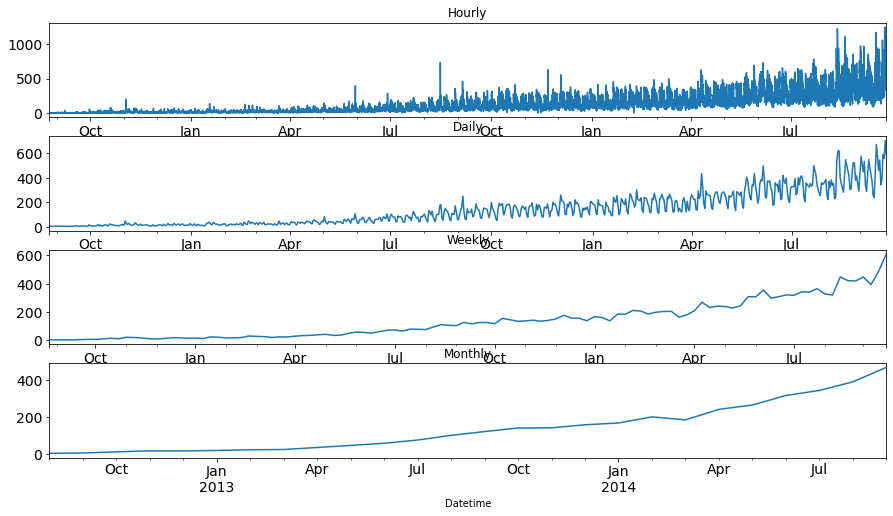

In [ ]:
fig, axs = plt.subplots(4, 1)
hourly.Count.plot(figsize = (15, 8), title = 'Hourly', fontsize = 14, ax = axs[0])
daily.Count.plot(figsize = (15, 8), title = 'Daily', fontsize = 14, ax = axs[1])
weekly.Count.plot(figsize = (15, 8), title = 'Weekly', fontsize = 14, ax = axs[2])
monthly.Count.plot(figsize = (15, 8), title = 'Monthly', fontsize = 14, ax = axs[3])
plt.show()

In [ ]:
# It would be difficult to convert monthly and weekly predictions to hourly predictions, so we work on daily time series
test.Timestamp = pd.to_datetime(test.Datetime, format = '%d-%m-%Y %H:%M')
test.index = test.Timestamp
# Converting to daily mean
test = test.resample('D').mean()

In [ ]:
train.Timestamp = pd.to_datetime(train.Datetime, format = '%d-%m-%Y %H:%M')
train.index = train.Timestamp
# Converting to daily mean
train = train.resample('D').mean()

# Modelling Techniques and Evaluation

In [ ]:
# Splitting the data into training and validation part
# We will take last 3 months as validation data and rest for training data
Train = train.loc['2012-08-25':'2014-06-24']
valid = train.loc['2014-06-25':'2014-09-25']

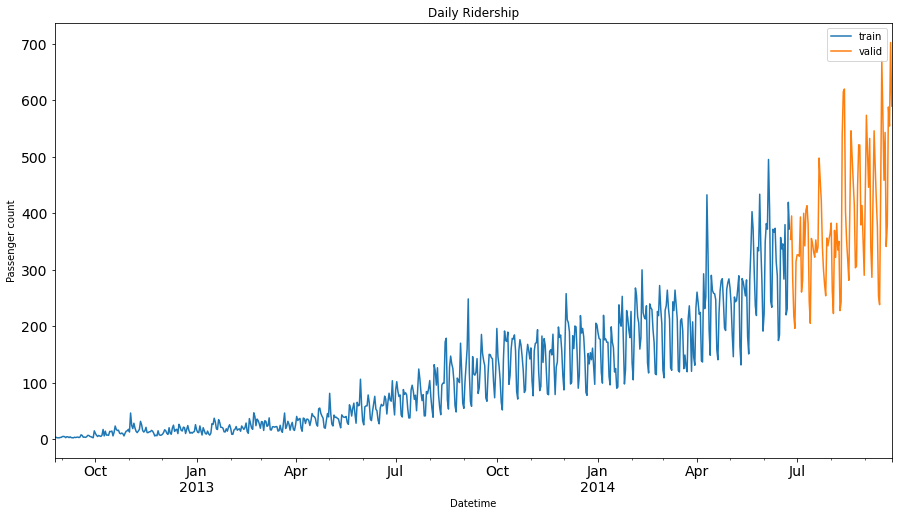

In [ ]:
Train.Count.plot(figsize=(15,8),title='Daily Ridership',fontsize=14,label='train')
valid.Count.plot(figsize=(15,8),title='Daily Ridership',fontsize=14,label='valid')
plt.xlabel('Datetime')
plt.ylabel('Passenger count')
plt.legend(loc='best')
plt.show()

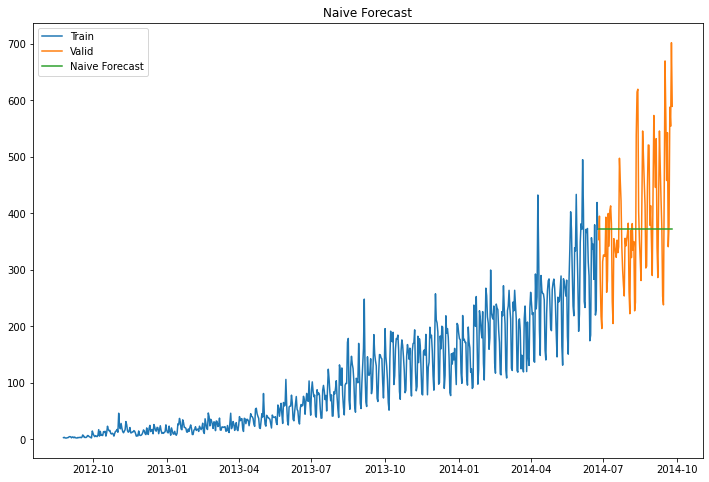

In [ ]:
# We will use different models to forecast the time series
# 1. Naive Approach --> assume next expected point is equal to last observed point
dd = np.asarray(Train.Count)
y_hat = valid.copy()
y_hat['naive'] = dd[len(dd) - 1]
plt.figure(figsize = (12, 8))
plt.plot(Train.index, Train['Count'], label = 'Train')
plt.plot(valid.index, valid['Count'], label = 'Valid')
plt.plot(y_hat.index, y_hat['naive'], label = 'Naive Forecast')
plt.legend(loc = 'best')
plt.title("Naive Forecast")
plt.show()

In [ ]:
# Calculate root mean square error to check the accuracy of our model on validation data set
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(valid.Count, y_hat.naive))
print(rms)

111.79050467496724


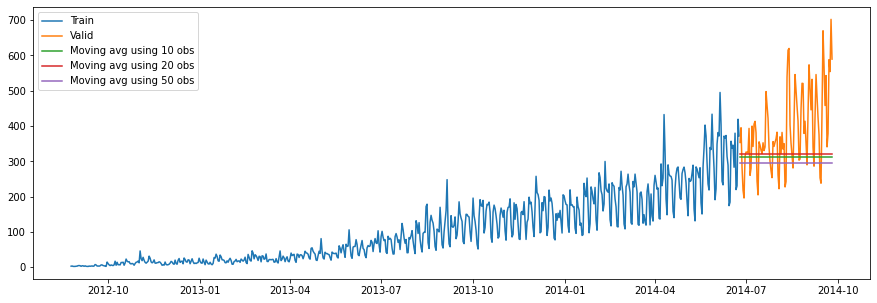

In [ ]:
# 2. Moving Average --> Take average of passenger count for last few time periods only
# Moving average or rolling mean for last 10, 20, 50 days
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast1'] = Train['Count'].rolling(10).mean().iloc[-1] # average of last 10 observations
y_hat_avg['moving_avg_forecast2'] = Train['Count'].rolling(20).mean().iloc[-1] # average of last 20 observations
y_hat_avg['moving_avg_forecast3'] = Train['Count'].rolling(50).mean().iloc[-1] # average of last 50 observations
plt.figure(figsize = (15, 5))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['moving_avg_forecast1'], label = 'Moving avg using 10 obs')
plt.plot(y_hat_avg['moving_avg_forecast2'], label = 'Moving avg using 20 obs')
plt.plot(y_hat_avg['moving_avg_forecast3'], label = 'Moving avg using 50 obs')
plt.legend(loc = 'best')
plt.show()

In [ ]:
rms1 = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast1))
print(rms1)
rms2 = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast2))
print(rms2)
rms3 = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast3))
print(rms3)

134.23733308950264
130.44984977550422
144.19175679986802


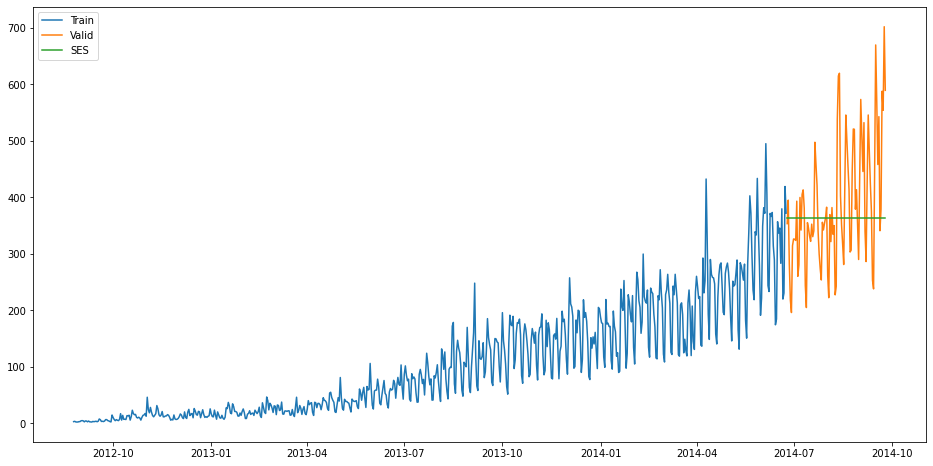

In [ ]:
# 3. Simple Exponential Smoothing --> Larger weights are assigned to recent values and lesser weights to older values
# Naive approach is also a kind of simple exponential smoothing where entire weight is given to last observed value
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['SES'], label = 'SES')
plt.legend(loc = 'best')
plt.show()

In [ ]:
rms = sqrt(mean_squared_error(valid['Count'], y_hat_avg['SES']))
print(rms)

113.43708111884514


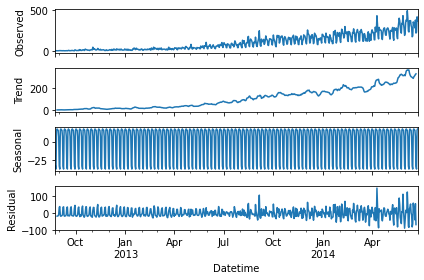

In [ ]:
# 4. Holt's Linear Trend Model --> Extension of SES to allow forecasting of data with a trend
# The forecast function in this method is a function of level and trend
import statsmodels.api as sm
sm.tsa.seasonal_decompose(Train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

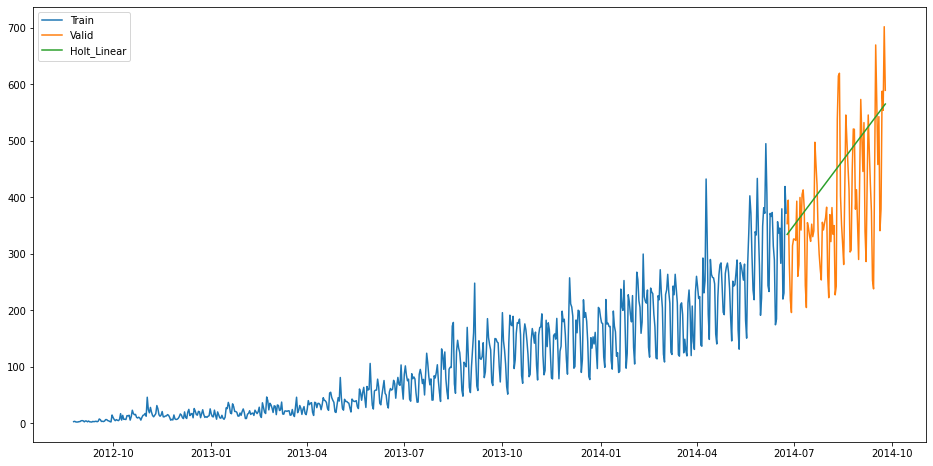

In [ ]:
# An increasing trend can be seen in the dataset so we will make model based on trend
y_hat_avg = valid.copy()
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level=0.3,smoothing_slope=0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))
plt.figure(figsize=(16, 8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['Holt_linear'], label = 'Holt_Linear')
plt.legend(loc = 'best')
plt.show()

In [ ]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_linear))
print(rms)

112.94278345314041


In [ ]:
# Holt's Linear trend model on daily time series
submission = pd.read_csv("https://raw.githubusercontent.com/DiwakarBasnet/JetRail/main/DateSet/Submission.csv")
predict = fit1.forecast(len(test))
test['prediction'] = predict
# calculating the hourly ratio of count
train_original['ratio'] = train_original['Count']/train_original['Count'].sum()
temp = train_original.groupby(['hour'])['ratio'].sum()
pd.DataFrame(temp, columns=['ratio']).to_csv('GROUPby.csv')   # Groupby to csv format

temp2 = pd.read_csv('GROUPby.csv')

# Merge test and test_original on day, month and year
merge = pd.merge(test, test_original, on=('day','month','year'), how='left')
merge['hour'] = merge['hour_y']
merge = merge.drop(['year','month','Datetime','hour_x','hour_y'], axis=1)
# Predicting by merging merge and temp2
prediction = pd.merge(merge, temp2, on='hour', how='left')
prediction['Count'] = prediction['prediction'] * prediction['ratio']  # converting ratio to original scale
prediction['ID'] = prediction['ID_y']

# Drop all the features from prediction file and keep ID and Count only
submission = prediction.drop(['ID_x','day','ID_y','prediction','hour','ratio'], axis=1)
# Converting submission to csv format
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt linear.csv')

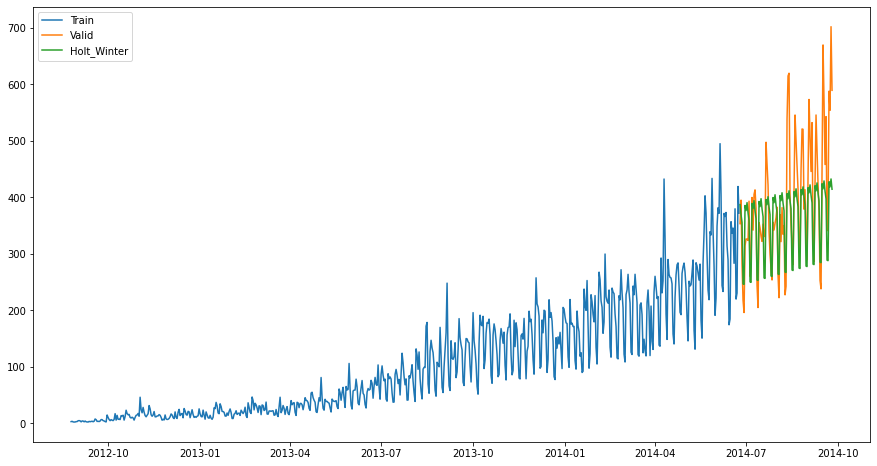

82.37571191747172


In [ ]:
# Holt Winter's model on daily time series
# Exponential Smoothing
y_hat_avg = valid.copy()
fit1 = ExponentialSmoothing(np.asarray(Train['Count']),  seasonal_periods=7, trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid))
plt.figure(figsize = (15, 8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['Holt_Winter'], label = 'Holt_Winter')
plt.legend(loc = 'best')
plt.show()

rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter))
print(rms)

In [ ]:
predict = fit1.forecast(len(test))
test['prediction'] = predict
# Merge test and test original on day, month and year
merge = pd.merge(test, test_original, on=('day','month','year'), how='left')
merge['hour'] = merge['hour_y']
merge = merge.drop(['year','month','Datetime','hour_x','hour_y'], axis=1)

# Predicting by merging merge and temp2
prediction = pd.merge(merge, temp2, on='hour', how='left')
# Converting ratio to original scale
prediction['Count'] = prediction['prediction'] * prediction['ratio'] * 24
prediction['ID'] = prediction['ID_y']
submission = prediction.drop(['ID_x','day','prediction','hour','ratio','ID_y'], axis = 1)

# Converting the final submission to csv format
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt winters.csv')


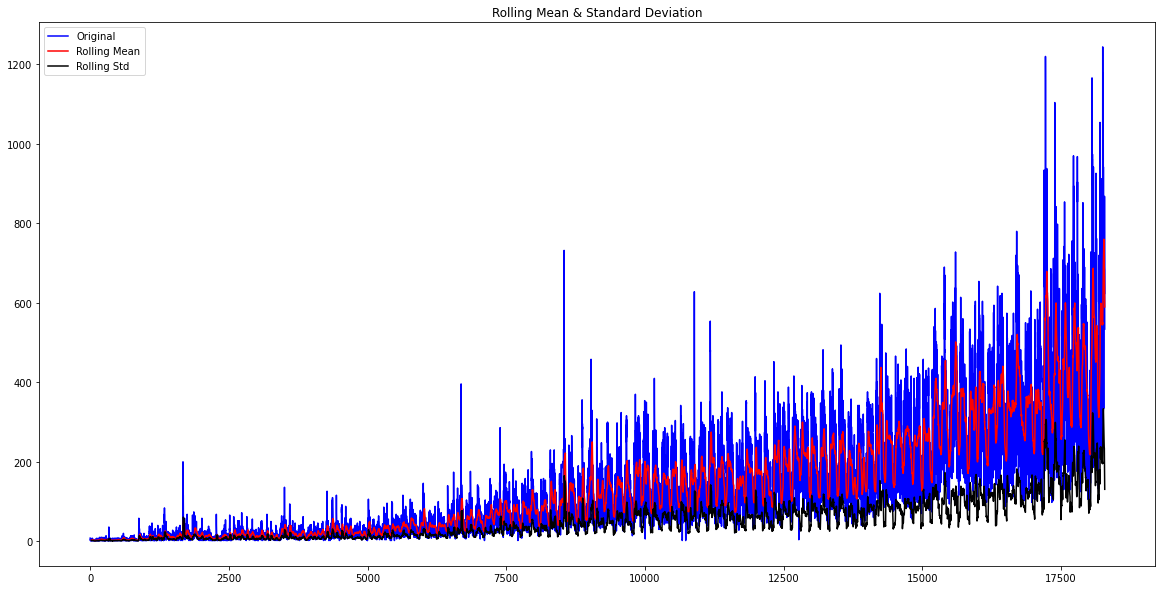

Results of Dickey fuller test: 
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [ ]:
# Parameter tuning for ARIMA model
# Stationary check --> using Dickey fuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
  # Determining rolling statistics
  rolmean = timeseries.rolling(24).mean()   # 24 hours on each day
  rolstd = timeseries.rolling(24).std()
  # Plot rolling statistics:
  orig = plt.plot(timeseries, color='blue', label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)
  # Perform Dickey fuller test
  print("Results of Dickey fuller test: ")
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
test_stationarity(train_original['Count'])

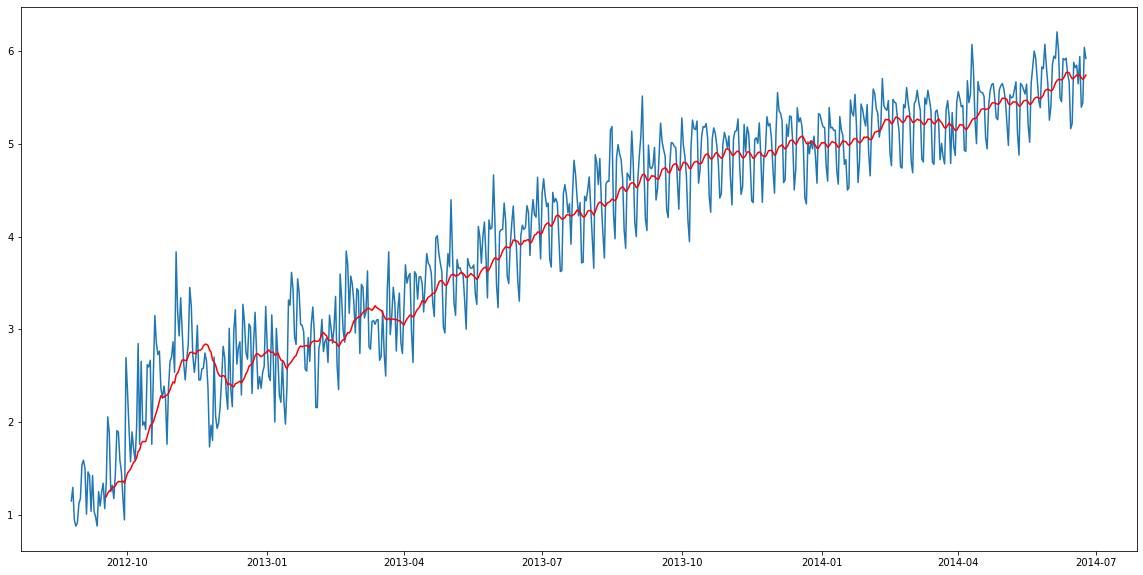

In [ ]:
# Test stats < Critical value --> time series is stationary
# But there is still increasing trend in data, so we will try to make data more stationary by removing trend and seasonality

# (i) Removing trend -
Train_log = np.log(Train['Count'])   # log --> log transformation
valid_log = np.log(valid['Count'])
moving_avg = Train_log.rolling(24).mean()
plt.plot(Train_log)
plt.plot(moving_avg, color='red')
plt.show()

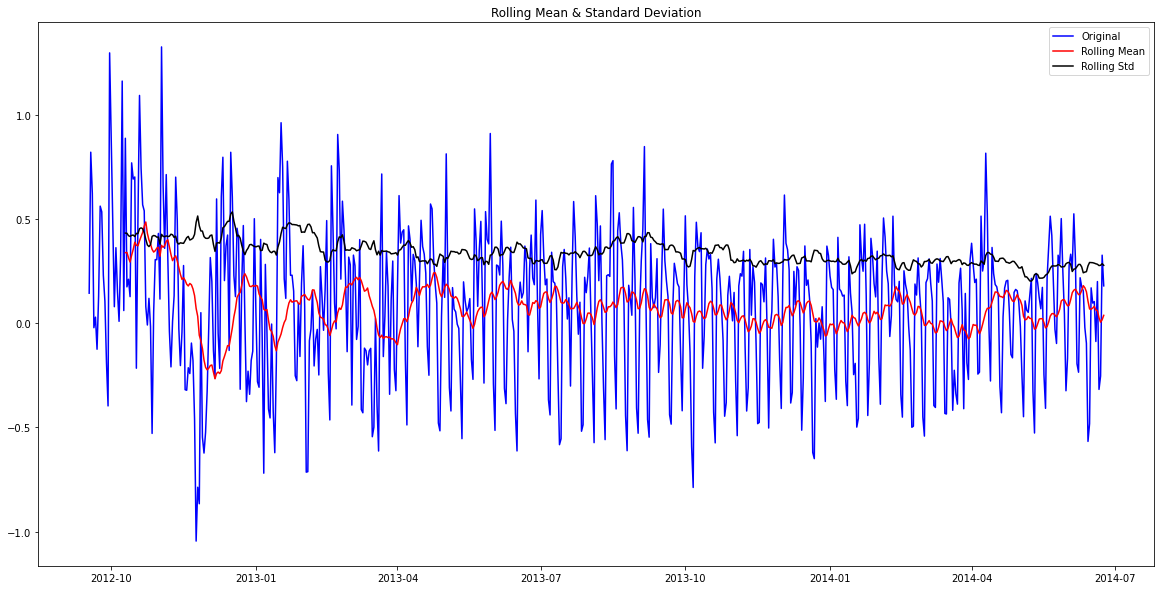

Results of Dickey fuller test: 
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
#Lags Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [ ]:
# we will remove this increasing trend to make our series stationary
train_log_moving_avg_diff = Train_log - moving_avg
train_log_moving_avg_diff.dropna(inplace=True)    # drop NA from first 24 values
test_stationarity(train_log_moving_avg_diff)

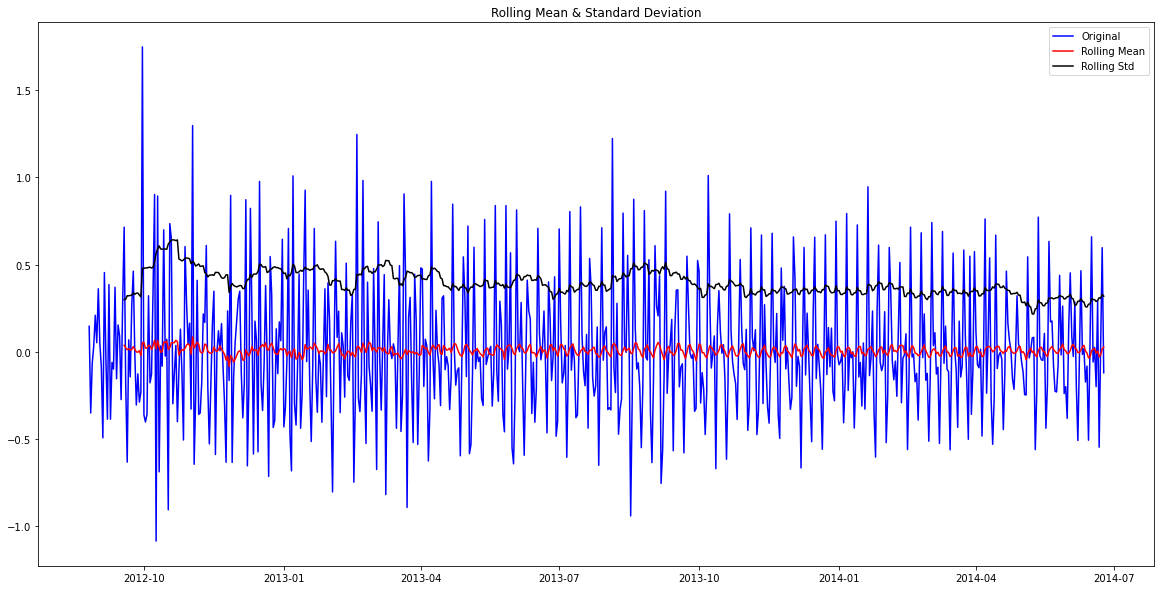

Results of Dickey fuller test: 
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [ ]:
# Stabilize the mean of the time series
train_log_diff = Train_log - Train_log.shift(1)
test_stationarity(train_log_diff.dropna())

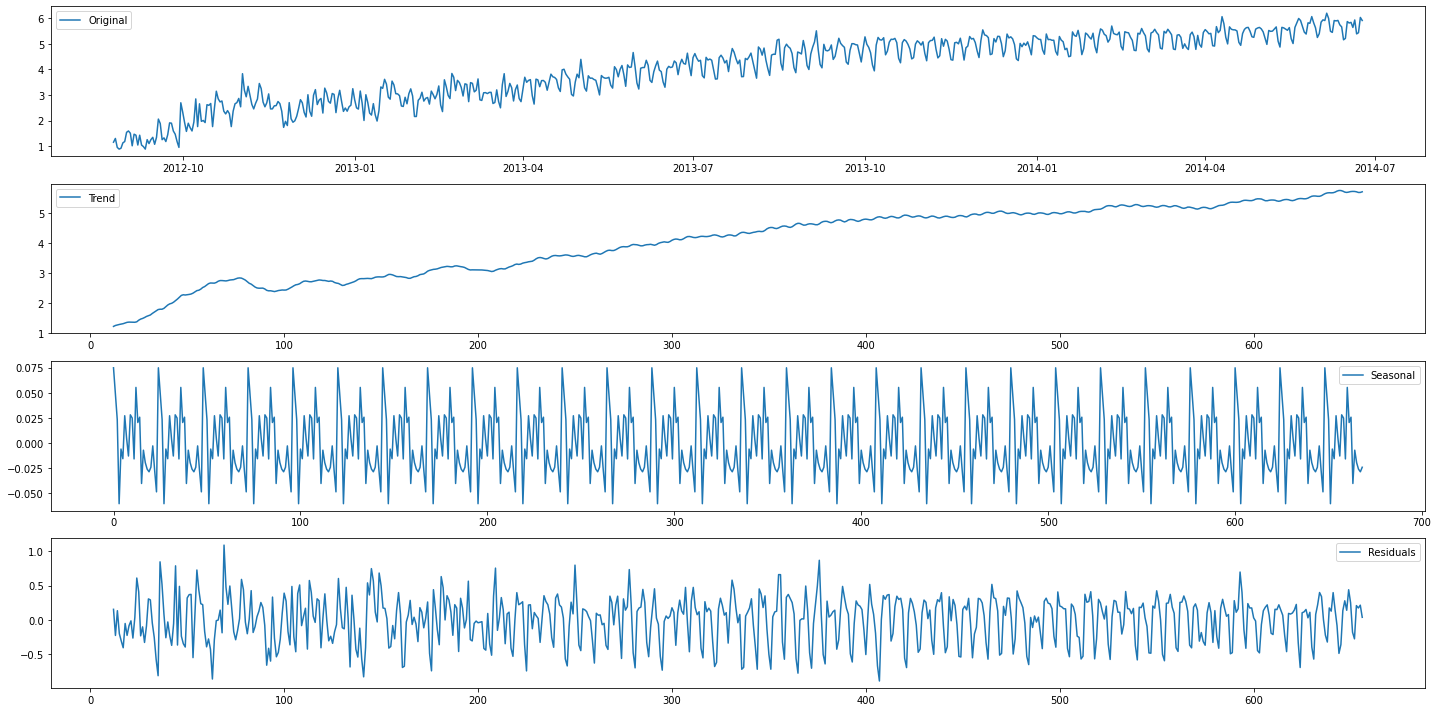

In [ ]:
# (ii) Removing seasonality -
# We will use seasonal decompose to decompose time series into trend, seasonality and residuals
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(Train_log, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

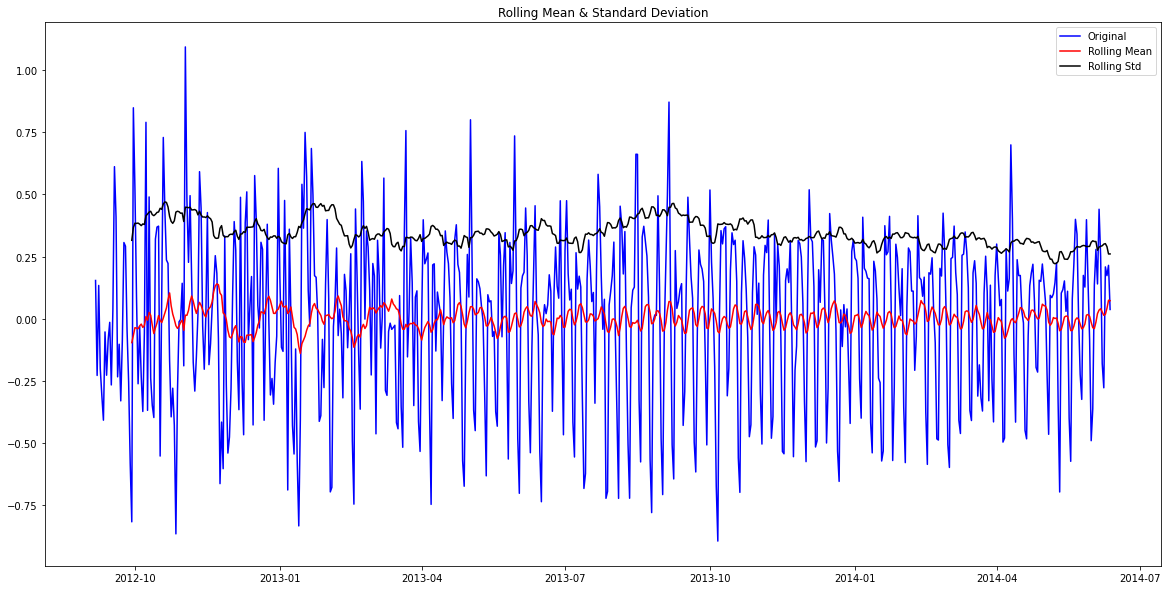

Results of Dickey fuller test: 
Test Statistic                -7.822096e+00
p-value                        6.628321e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [ ]:
# Check the stationarity of residuals
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = Train_log.index
train_log_decompose.set_index('date', inplace = True)   # inplace --> data is modified and will return nothing
train_log_decompose.dropna(inplace = True)
test_stationarity(train_log_decompose[0])

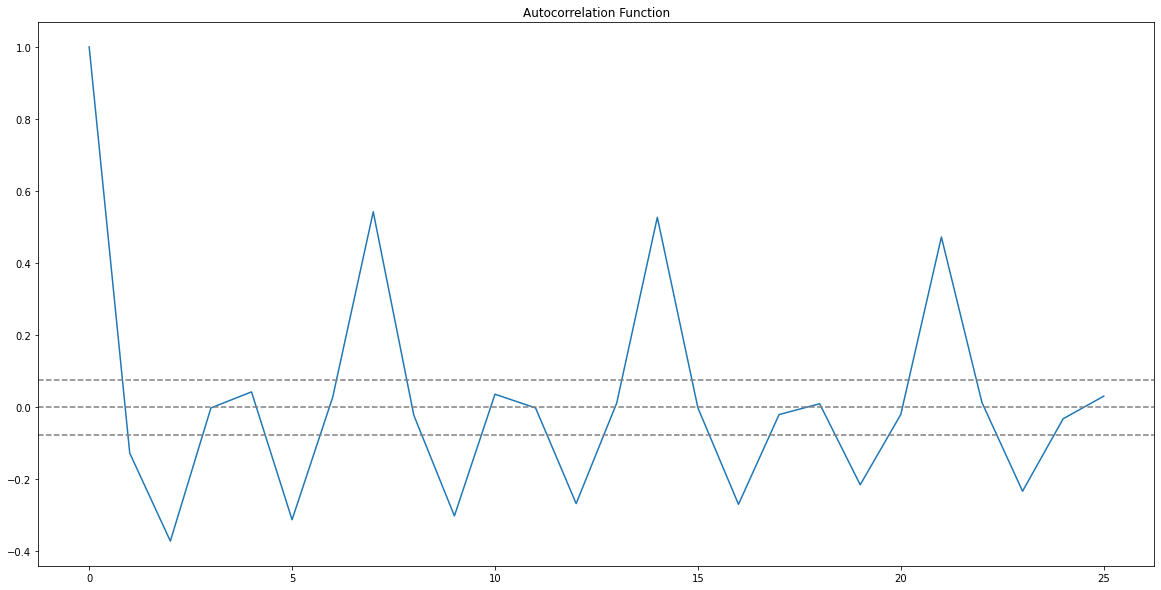

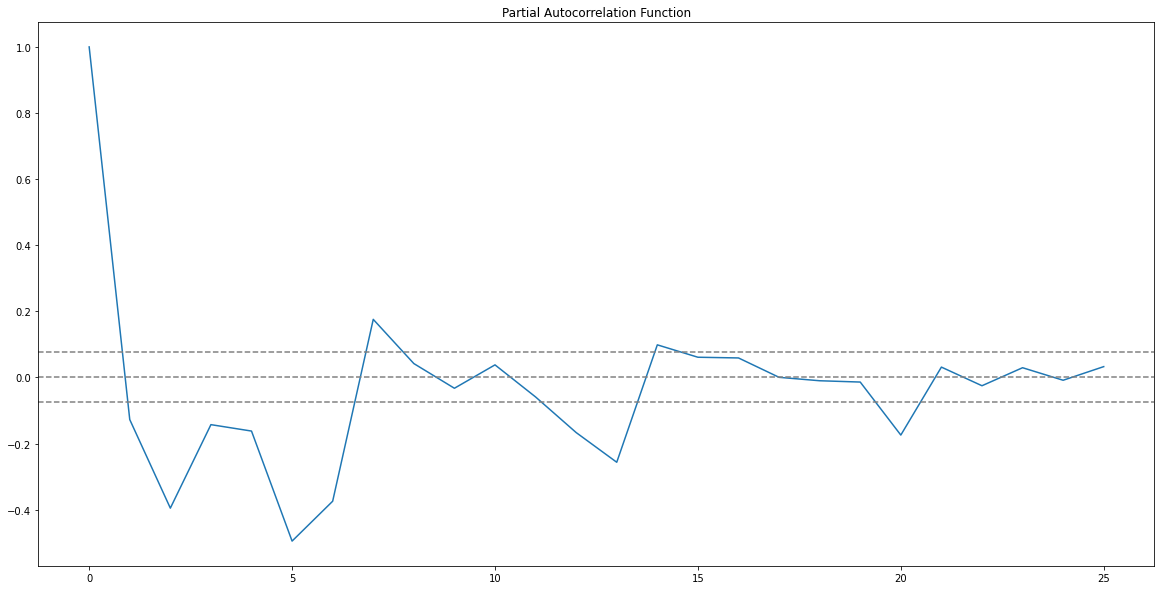

In [ ]:
# Forecasting the time series using ARIMA
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(train_log_diff.dropna(), nlags = 25)
lag_pacf = pacf(train_log_diff.dropna(), nlags = 25, method = 'ols')

plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.show()

plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

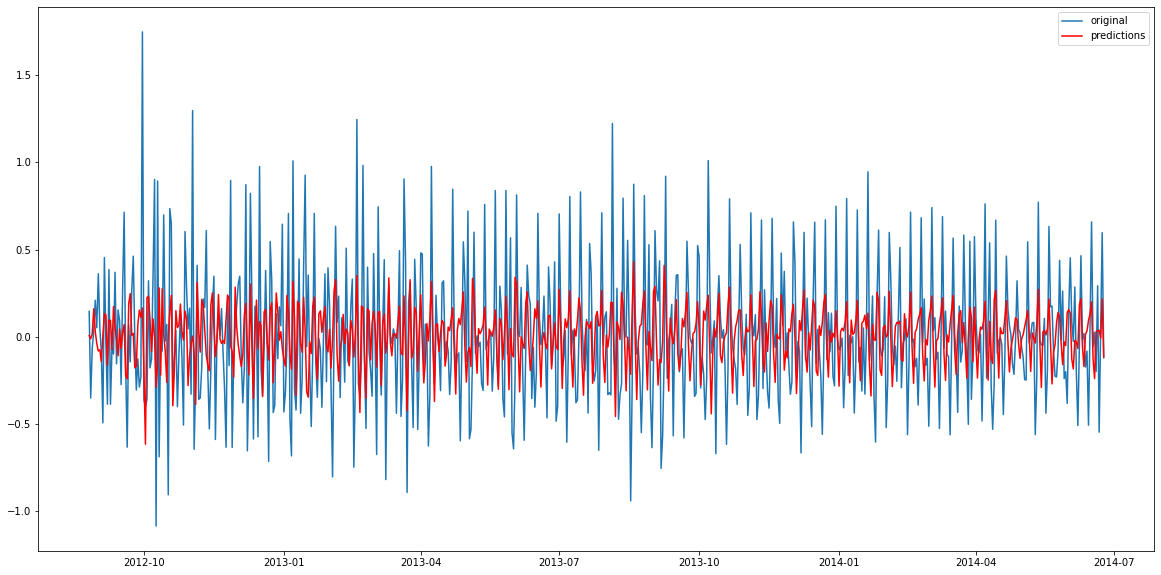

In [ ]:
# AR Model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Train_log, order = (2,1,0))  # since it is just AR model q=0
results_AR = model.fit(disp=-1)  # since disp < 0 there is no output
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(results_AR.fittedvalues, color='red', label='predictions')
plt.legend(loc='best')
plt.show()

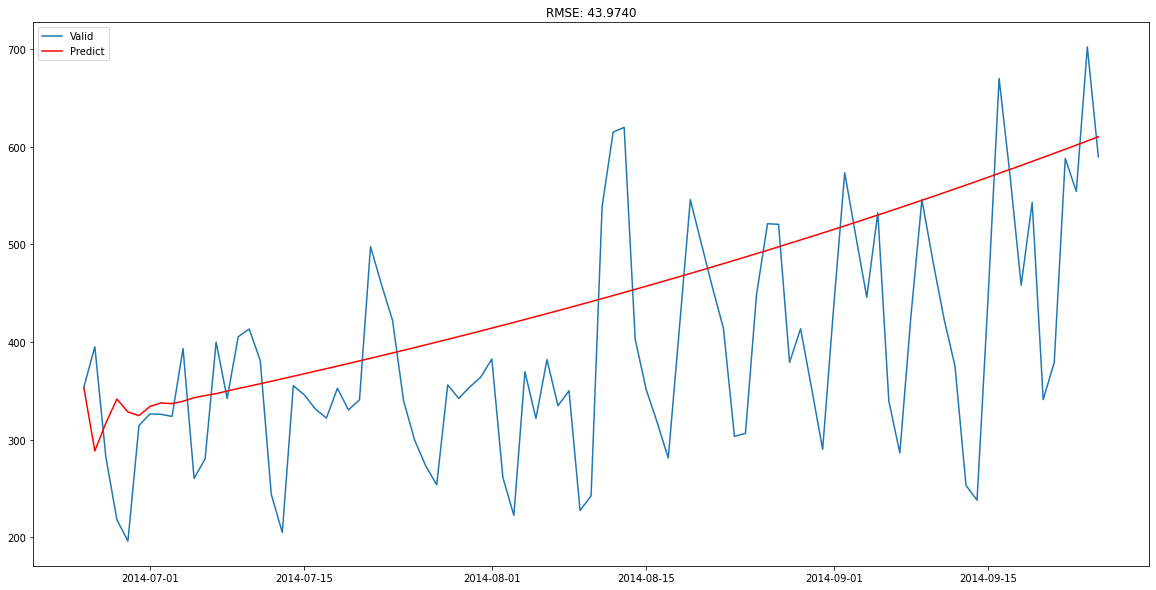

In [ ]:
AR_predict = results_AR.predict(start="2014-06-25", end="2014-09-25")
AR_predict = AR_predict.cumsum().shift().fillna(0)
AR_predict1 = pd.Series(np.ones(valid.shape[0])*np.log(valid['Count'])[0],index=valid.index)
AR_predict1 = AR_predict1.add(AR_predict, fill_value=0)
AR_predict = np.exp(AR_predict1)

plt.plot(valid['Count'], label="Valid")
plt.plot(AR_predict, color='red', label="Predict")
plt.legend(loc='best')
plt.title('RMSE: %.4f'%(np.sqrt(np.dot(AR_predict, valid['Count']))/valid.shape[0]))
plt.show()

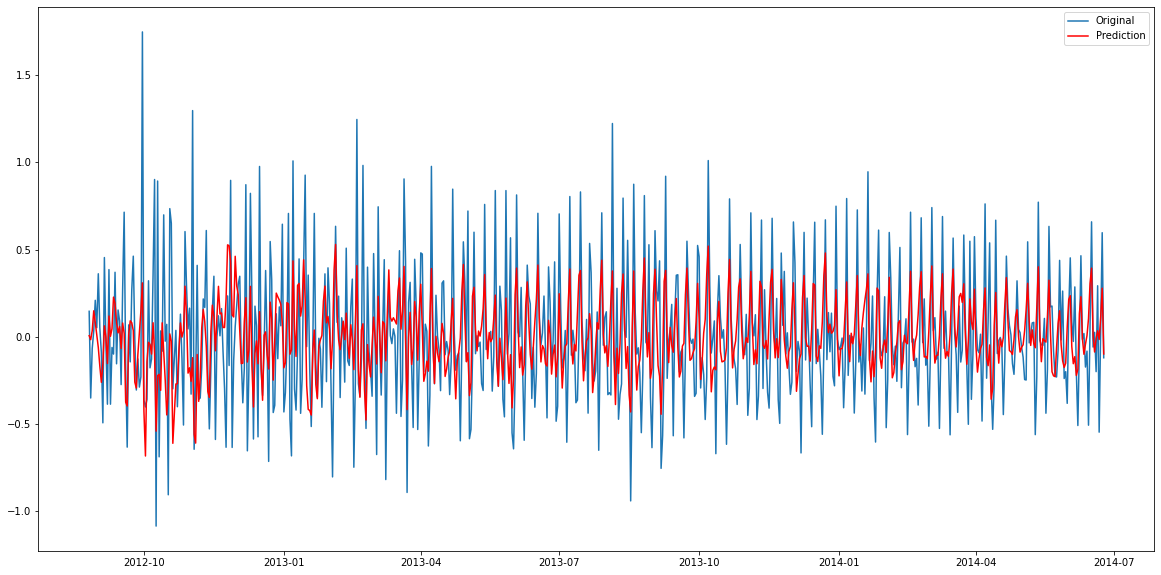

In [ ]:
# MA model
model = ARIMA(Train_log, order=(0,1,2)) # since it is just MA model p=0
results_MA = model.fit(disp=-1)
plt.plot(train_log_diff.dropna(), label='Original')
plt.plot(results_MA.fittedvalues, color='red', label='Prediction')
plt.legend(loc='best')
plt.show()

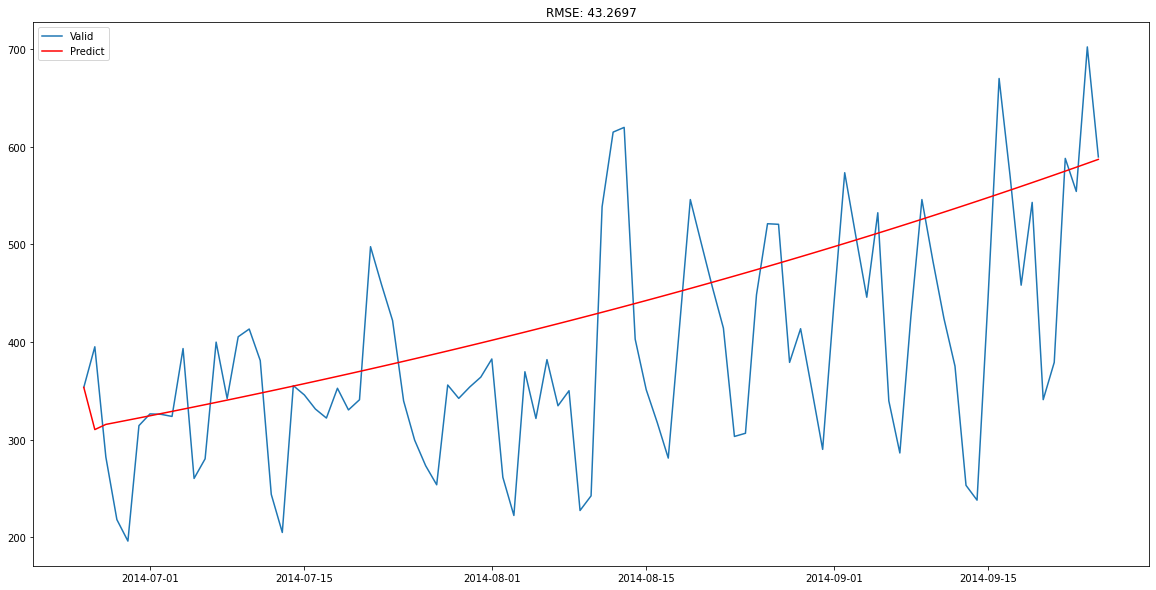

In [ ]:
MA_predict = results_MA.predict(start="2014-06-25", end="2014-09-25")
MA_predict = MA_predict.cumsum().shift().fillna(0)
MA_predict1 = pd.Series(np.ones(valid.shape[0])*np.log(valid['Count'])[0],index=valid.index)
MA_predict1 = MA_predict1.add(MA_predict, fill_value=0)
MA_predict = np.exp(MA_predict1)

plt.plot(valid['Count'], label='Valid')
plt.plot(MA_predict, color='red', label='Predict')
plt.legend(loc='best')
plt.title('RMSE: %.4f'%(np.sqrt(np.dot(MA_predict, valid['Count']))/valid.shape[0]))
plt.show()

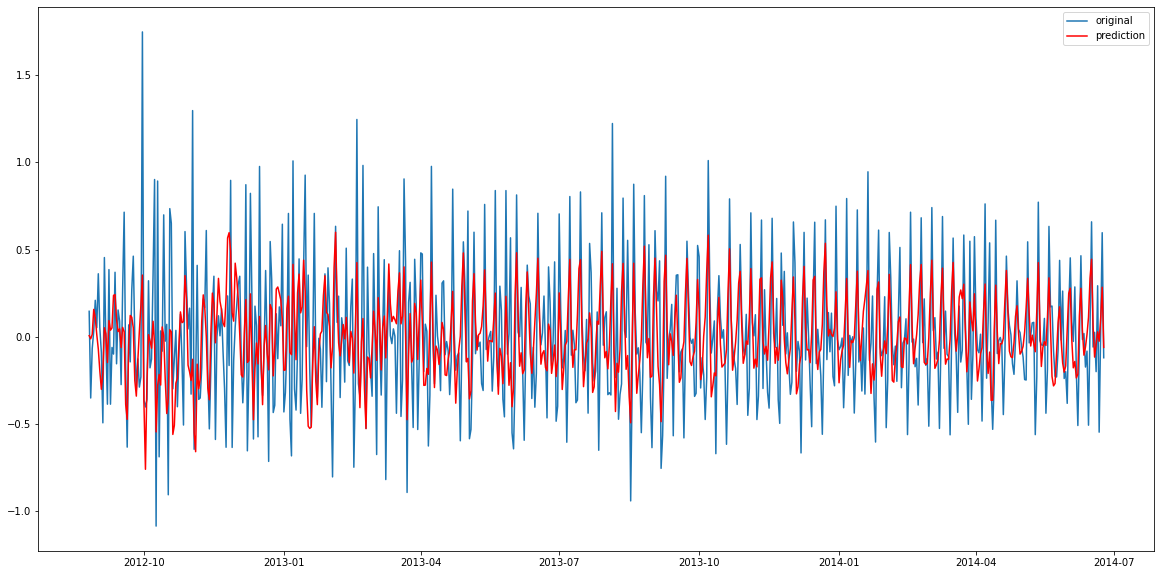

In [ ]:
# Combined model
model = ARIMA(Train_log, order = (2,1,2))
results_ARIMA = model.fit(disp = -1)

plt.plot(train_log_diff.dropna(), label = 'original')
plt.plot(results_ARIMA.fittedvalues, color = 'red', label = 'prediction')
plt.legend(loc = 'best')
plt.show()

In [ ]:
# Lets define a  function which can be used to change the scale of model to original scale
def check_prediction_diff(predict_diff, given_set):
  predict_diff = predict_diff.cumsum().shift().fillna(0)
  predict_base = pd.Series(np.ones(given_set.shape[0])*np.log(given_set['Count'])[0],index=given_set.index)
  predict_log = predict_base.add(predict_diff, fill_value = 0)
  predict = np.exp(predict_log)

  plt.plot(given_set['Count'], label = 'Given set')
  plt.plot(predict, color = 'red', label = 'Predict')
  plt.legend(loc = 'best')
  plt.title('RMSE: %.4f'%(np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
  plt.show()

def check_prediction_log(predict_log, given_set):  # Don't know why this function is made because above function does same work
  predict = np.exp(predict_log)

  plt.plot(given_set['Count'], label = 'Given set')
  plt.plot(predict, color = 'red', label = 'Predict')
  plt.legend(loc = 'best')
  plt.title('RMSE: %.4f'%(np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
  plt.show

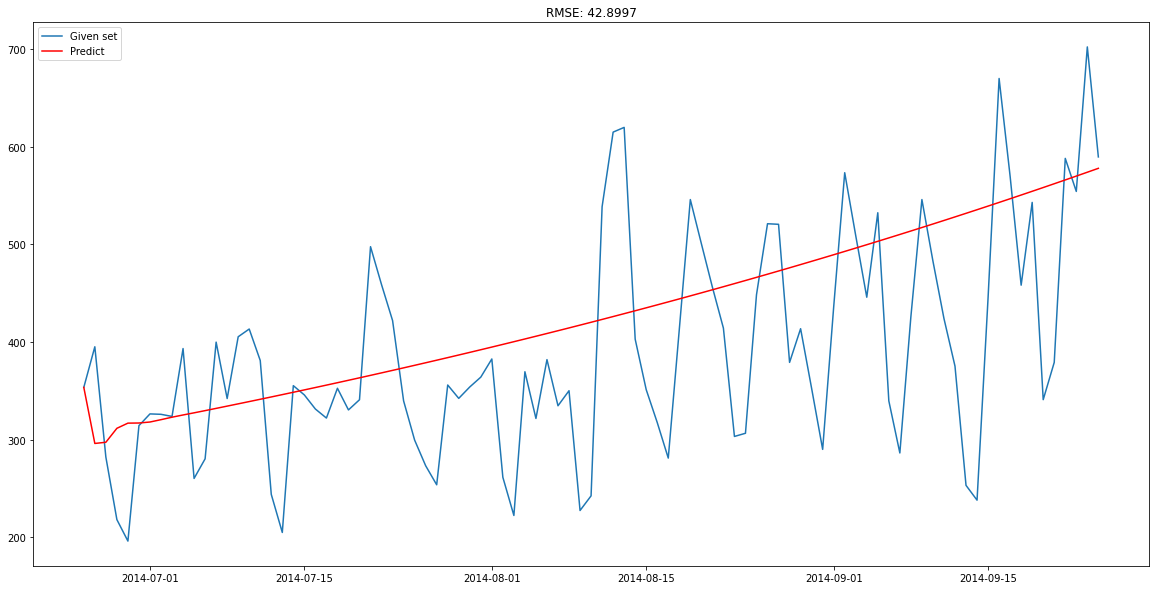

In [ ]:
# Predict the values of validation set:
ARIMA_predict_diff = results_ARIMA.predict(start="2014-06-25", end="2014-09-25")
check_prediction_diff(ARIMA_predict_diff, valid)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


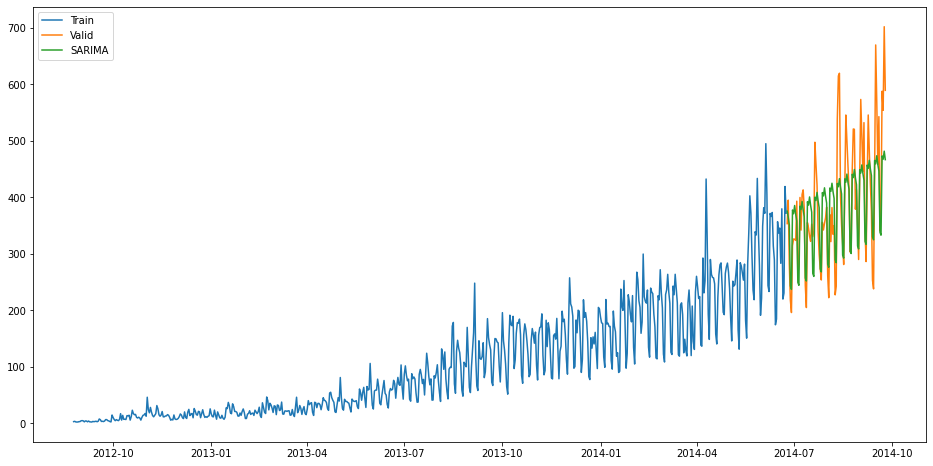

In [ ]:
# SARIMAX model
import statsmodels.api as sm
y_hat_avg = valid.copy()
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order=(2,1,4), seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2014-06-25", end="2014-09-25", dynamic=True)
plt.figure(figsize = (16, 8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['SARIMA'], label = 'SARIMA')
plt.legend(loc = 'best')
plt.show()

In [ ]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SARIMA))
print(rms)

69.7096906968534


In [ ]:
# Forecasting time series for Test data
predict = fit1.predict(start="2014-09-26", end="2015-04-26", dynamic=True)

test['prediction'] = predict

# Merge Test and test_original on day, month and year
merge = pd.merge(test, test_original, on=('day','month','year'),how='left')
merge['hour'] = merge['hour_y']
merge = merge.drop(['year', 'month', 'Datetime', 'hour_x', 'hour_y'], axis=1)

# Predicting by merging merge and temp2
prediction = pd.merge(merge, temp2, on='hour', how='left')

# Converting the ratio to original scale
prediction['Count'] = prediction['prediction']*prediction['ratio']*24

prediction['ID'] = prediction['ID_y']
submission = prediction.drop(['day','hour','ratio','prediction','ID_x','ID_y'],axis=1)

# Converting the final submission to csv format
pd.DataFrame(submission, columns=['ID','Count']).to_csv('SARIMAX.csv')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)
